In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 
from tqdm import tqdm, trange
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim 
from torch.utils.data import DataLoader
from scipy import signal

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cpu'

In [2]:
train_data = pd.read_csv(r"C:\Users\Asus\Documents\Programming\data\mnist\mnist_train.csv")
test_data = pd.read_csv(r"C:\Users\Asus\Documents\Programming\data\mnist\mnist_test.csv")
train_data.shape, test_data.shape

((60000, 785), (10000, 785))

In [3]:
train, test = train_data.values, test_data.values
train.shape, test.shape

((60000, 785), (10000, 785))

In [4]:
y_train, x_train = train[:, 0], train[:, 1:].reshape(-1, 28, 28)
y_test, x_test = test[:, 0], test[:, 1:].reshape(-1, 28, 28)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [300]:
train_dataloader = DataLoader(list(zip(x_train, y_train)), batch_size=64, num_workers=0, shuffle=True) 
test_dataloader = DataLoader(list(zip(x_test, y_test)), batch_size=64, num_workers=0, shuffle=False, drop_last=True) 

# Doing it in PyTorch First

In [42]:
class torch_net(nn.Module): 
    def __init__(self): 
        super(torch_net, self).__init__()
        self.conv = nn.Conv2d(1, 10, (3, 3), bias=False)
        self.maxpool = nn.MaxPool2d(2)
        self.linear = nn.Linear(1690, 10, bias=False)
        
    def forward(self, x): 
        out = self.conv(x)
        out = F.relu(out)
        out = self.maxpool(out)
        out = F.log_softmax(self.linear(out.view(-1, 10*13*13)), dim=1)
        return out

Epochs 1000/1000: 100%|████████████████████████████████████| 1000/1000 [00:08<00:00, 121.23it/s, acc=0.844, loss=0.342]


(0.0, 1.0)

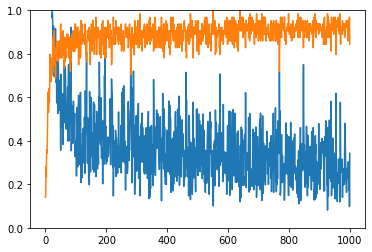

In [49]:
model = torch_net()
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=7e-2)#lr=75e-3)
losses, accuracies = list(), list() 
n_epochs = 1000
for epoch in (loop := trange(n_epochs)): 
    sample = np.random.randint(0, 60000, size=64)
    #for x, y in (loop := tqdm(train_dataloader)): 
    x, y = (torch.tensor(x_train[sample], dtype=torch.float)/255).view(-1, 1, 28, 28), torch.tensor(y_train[sample], dtype=torch.long)
    out = model(x) 
    model.zero_grad()
    cat = out.argmax(dim=1, keepdim=True)
    acc = (cat == y.view(-1, 1)).float().mean().item()
    loss = loss_fn(out, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    accuracies.append(acc)
    loop.set_description(f"Epochs {epoch+1}/{n_epochs}")
    loop.set_postfix(loss=loss.item(), acc=acc)
plt.plot(losses)
plt.plot(accuracies)
plt.ylim(0, 1)

In [50]:
correct = 0
with torch.no_grad(): 
    model.eval()
    for x, y in tqdm(test_dataloader): 
        x = (x/255).view(-1, 1, 28, 28)
        out = model(x) 
        cat = out.argmax(dim=1, keepdim=True)
        correct += (cat == y.view(-1, 1)).float().sum().item()
print(f"Accuracy: {correct/100}")

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 99.49it/s]

Accuracy: 91.58


In [51]:
conv_w = model.conv.weight.detach().numpy()
lin_w = model.linear.weight.detach().numpy()
conv_w.shape, lin_w.shape

((10, 1, 3, 3), (10, 1690))

# Doing it in NumPy

In [307]:
class numpy_network():
    def __init__(self, lr, bs):
        self.bs = bs
        self.lr = lr
        self.conv_w = np.random.uniform(-1., 1., size=(10, 1, 3, 3))
        self.lin_w = np.random.uniform(-1., 1., size=(10, 1690))
        
        self.x_kernel = np.zeros([676, self.bs, 9], dtype=np.float32)
        self.conv_out = np.empty([self.bs, 10, 676], dtype=np.float32)
        self.relu_out = np.empty([self.bs, 10, 676], dtype=np.float32)
        self.max_idx = np.empty([108160], dtype=np.int32)
        self.max_out = np.empty([self.bs, 10, 26, 26], dtype=np.float32)
        self.lin_out = np.empty([self.bs, 10], dtype=np.float32)
        self.lsm_out = np.empty([self.bs, 10], dtype=np.float32)
        self.one_hot_out = np.zeros([self.bs, 10], dtype=np.float32)
        self.loss = 0.0
        
    def fill_x_kernels(self, x): 
        idx = 0
        for i in range(3, x.shape[2]+1): 
            for j in range(3, x.shape[3]+1): 
                self.x_kernel[idx] = x[:, :, i-3:i, j-3:j].reshape(1, self.bs, 9)
                idx += 1
                
    def forward(self, x, network): 
        network.fill_x_kernels(x)
        self.conv_out = np.dot(self.conv_w.reshape(10, 9), self.x_kernel.transpose(1, 2, 0)).transpose(1, 0, 2)
        self.relu_out = np.maximum(self.conv_out, 0)
        new_relu_out = net.relu_out.reshape(self.bs, 10, 13, 2, 13, 2).transpose(0, 1, 2, 4, 3, 5).reshape(-1, 4)
        self.max_idx = np.argmax(new_relu_out, axis=1)
        self.max_out = new_relu_out[range(self.max_idx.size), self.max_idx]
        #####self.max_out = self.relu_out.reshape(64, 10, 13, 2, 13, 2).max(axis=(3, 5))
        self.lin_out = self.max_out.reshape(self.bs, -1).dot(self.lin_w.T)
        replace = self.lin_out-np.max(self.lin_out, axis=1).reshape(-1, 1)
        self.lsm_out = replace - np.log(np.sum(np.exp(replace), axis=1)).reshape(-1, 1)
    
    def loss_function(self, out, y):
        self.one_hot_out = np.zeros((self.bs, 10), dtype=np.float32)
        self.one_hot_out[range(self.one_hot_out.shape[0]), y.reshape(-1)] = 1
        
        self.loss = -(self.one_hot_out * out).sum(axis=1).mean()
        
    def back_propagation(self, x): 
        dl_lsm = (-self.one_hot_out)/(len(self.one_hot_out))
        dl_lin = dl_lsm - np.exp(self.lsm_out)*dl_lsm.sum(axis=1).reshape(-1, 1)
        dl_w = dl_lin.T.dot(self.max_out.reshape(self.bs, -1))
        dl_max_out = dl_lin.dot(self.lin_w)
        
        dl_relu = np.zeros((self.bs*10*13*13, 4))
        dl_relu[range(self.max_idx.size), self.max_idx.reshape(self.bs*10*13*13)] = dl_max_out.reshape(self.bs*10*13*13)
        temp = dl_relu.copy()
        dl_relu[:, 1] = temp[:, 2]
        dl_relu[:, 2] = temp[:, 1]
        dl_relu = dl_relu.reshape(-1).reshape(self.bs, 10, 26, 13, 2).transpose(0, 1, 2, 4, 3).reshape(self.bs, 10, 13, 2, 2, 13).transpose(0, 1, 2, 4, 3, 5).reshape(self.bs, 10, 26, 26)

        dl_conv = (self.relu_out > 0).astype(np.float32).reshape(self.bs, 10, 26, 26) * dl_relu
        
        dl_filter = np.dot(dl_conv.transpose(1, 2, 3, 0).reshape(10, -1), net.x_kernel.reshape(-1, 9))
    
        self.lin_w -= self.lr * dl_w
        self.conv_w -= self.lr * dl_filter.reshape(10, 1, 3, 3)

Epochs 2000: 100%|███████████████████████████████████████████| 2000/2000 [01:39<00:00, 20.13it/s, acc=0.766, loss=0.73]


(0.0, 1.0)

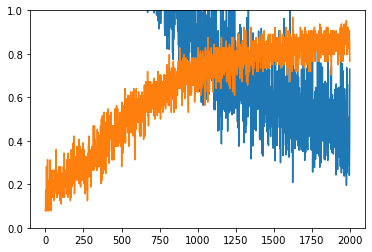

In [308]:
net = numpy_network(0.07, 64)
losses, accuracies = list(), list()
for epoch in (loop := trange(2000)): 
    sample = np.random.randint(0, 60000, size=64)
    x, y = x_train[sample].reshape(-1, 1, 28, 28)/255, y_train[sample].reshape(-1, 1)
    
    net.forward(x, net)
    net.loss_function(net.lsm_out, y)
    net.back_propagation(x)
    
    acc = (net.lsm_out.argmax(axis=1).reshape(-1, 1) == y).mean()
    losses.append(net.loss)
    accuracies.append(acc) 
    
    loop.set_description(f"Epochs {epoch+1}")
    loop.set_postfix(loss=net.loss, acc=acc)
plt.plot(losses)
plt.plot(accuracies)
plt.ylim(0, 1)

In [309]:
acc = 0

for x, y in tqdm(test_dataloader): 
    x, y = np.asarray(x.view(-1, 1, 28, 28)/255), np.asarray(y.view(-1, 1))
    out = net.forward(x, net)
    acc += (net.lsm_out.argmax(axis=1).reshape(-1, 1) == y).sum()
print(f"Accuracy: {acc/(156*64)}")

100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:04<00:00, 32.44it/s]

Accuracy: 0.8637820512820513
